In [4]:
# libraries for querying astro images and processing them
from astroquery.alma import Alma
from astroquery.skyview import SkyView
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.modeling import models, fitting
from astropy.convolution import convolve, interpolate_replace_nans
from astropy.convolution import Gaussian2DKernel
from astropy.stats import sigma_clip, sigma_clipped_stats
from astropy.table import *
import os
import skimage
from skimage.filters import *
import numpy as np
from skimage import io, exposure, morphology, filters, feature
from skimage.feature import blob_dog, blob_log, blob_doh
import cv2
from math import sqrt
import scipy.optimize as opt
import statmorph
import photutils
import scipy.ndimage as ndi
import pandas as pd
from scipy import ndimage

# plotting libraries
from matplotlib import pylab
import pylab as py
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# libraries for machine learning
from sklearn import decomposition
from sklearn import preprocessing

# libraries for deep learning
import torch
from torchvision import transforms
from torchvision import datasets

# random libraries
import time
import math
import warnings
import pickle
import random

import multiprocessing as mp

plt.style.use(astropy_mpl_style)
sns.reset_orig()

torch.manual_seed(69)
np.random.seed(69)
random.seed(69)

In [5]:
with open('full_data.pickle', 'rb') as f:
    full_data = pickle.load(f)
    

In [6]:
scaled_data = []

for img in list(full_data.values())[:]:
    scale_factor = 1/(img.max()-img.min())
    img_scaled = (img-img.min())*scale_factor
    scaled_data.append(img_scaled)

scaled_data = np.array(scaled_data)
     

In [7]:
print(np.array(list(full_data.values())[:]).shape)

(12540, 100, 100)


In [8]:
class GalacticDataset(torch.utils.data.Dataset):
    
    def __init__(self, X):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X).reshape((X.shape[0], 1, X.shape[1], X.shape[2]))
            
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i]
    
    
BATCH_SIZE = 256

X = scaled_data[:]
dataset = GalacticDataset(X=X[:5096])
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,)

In [10]:
# Creating a PyTorch class
# 100*100 ==> 18 ==> 100*100
class VAE(torch.nn.Module):
    def __init__(self):
        super().__init__()
          
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 10000 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(100 * 100, 516),
            torch.nn.BatchNorm1d(516),
            torch.nn.ReLU(),
            torch.nn.Linear(516, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
        )
        
        self.log_var = torch.nn.Sequential(
            torch.nn.Linear(64, 2)
        )
        
        self.mean = torch.nn.Sequential(
            torch.nn.Linear(64, 2)
        )
        
        
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 10000
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 516),
            torch.nn.BatchNorm1d(516),
            torch.nn.ReLU(),
            torch.nn.Linear(516, 100 * 100),
            torch.nn.Sigmoid()
        )
  
    def reparameterise(self, means, log_vars): # mu = mean of latent space, log_var = log variance of latent space
        std = torch.exp(log_vars)
        eps = torch.randn_like(std) # sample from X~norm(0, 1)
        sample = means + (eps*std) # scale by std, shift by mean
        
        return sample
        
    def forward(self, x):
        
        means, log_vars = self.encode(x)
        z = self.reparameterise(means, log_vars)
        decoded = self.decoder(z)
        
        return decoded, means, log_vars
    
    def decode(self, x):
        return self.decoder()
    
    def encode(self, x):      
        
        encoded = self.encoder(x)
        means = self.mean(encoded)
        log_vars = self.log_var(encoded)

        return means, log_vars

    
def vae_loss(orig, reconstructed, means, log_vars, beta=0, A=0, C=0, D=0):
    """
    Reference: 
    https://towardsdatascience.com/beginner-guide-to-variational-autoencoders-vae-with-pytorch-lightning-13dbc559ba4b
    """
    
#     reconstruction_loss = ((orig - reconstructed)**2).sum()
    recon = torch.nn.HuberLoss()
    reconstruction_loss = recon(orig, reconstructed)
    kl_loss = ((means**2 + (torch.exp(log_vars))**2 - 0.5 - log_vars).sum())/BATCH_SIZE
    
    cov_matrix = torch.cov(means.t())
    cov_loss = torch.abs(cov_matrix[0][1])
    
    loss = A*reconstruction_loss + beta*torch.abs(kl_loss - C) + D*(cov_loss)

    return loss, kl_loss, reconstruction_loss, cov_loss

# Model Initialization
model = VAE()

  


In [11]:
losses_epoch = []
kl_losses_epoch = []
recon_losses_epoch = []
cov_losses_epoch = []

In [273]:
# Using an Adam Optimizer with lr = 0.001
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.001)


outputs = []
epochs = 50
for epoch in range(epochs):
    for (image) in loader:

        losses = []
        kl_losses = []
        recon_losses = []
        cov_losses = []
        
      # Reshaping the image to (-1, 10000)
        image = image.reshape(-1, 100*100)

        # Output of Autoencoder
        reconstructed, means, log_vars = model(image)
#       print(means)
        
        # Calculating the loss function
        loss, kl_loss, reconstruction_loss, cov_loss = vae_loss(image, reconstructed, means, log_vars, beta=8e-5, 
                                                                A=1, C=0, D=0)
#         print(kl_loss)
#         print(reconstruction_loss)
#         print(loss)
        # The gradients are set to zero,
        # the the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Storing the losses in a list for plotting

        losses.append(loss.detach())
        kl_losses.append(kl_loss.detach())
        recon_losses.append(reconstruction_loss.detach())
        cov_losses.append(cov_loss.detach())
        
        if epoch == epochs-1:
            outputs.append([image, reconstructed])
            
    losses_epoch.append(losses)
    kl_losses_epoch.append(kl_losses)
    recon_losses_epoch.append(recon_losses)
    cov_losses_epoch.append(cov_losses)
    
    l = sum(losses)/len(losses)
#         outputs.append((epochs, image, reconstructed))
    print('epoch [{}/{}]'.format(epoch + 1, epochs,), f'Loss: {l}', f'KL Loss {sum(kl_losses)/len(kl_losses)}',
         f'Recon Loss {sum(recon_losses)/len(recon_losses)}', f'Cov Loss {sum(cov_losses)/len(cov_losses)}')
        


epoch [1/50] Loss: 0.0010146130807697773 KL Loss 4.678481578826904 Recon Loss 0.0006403345614671707 Cov Loss 0.018335601314902306
epoch [2/50] Loss: 0.0010230491170659661 KL Loss 4.576159477233887 Recon Loss 0.0006569563411176205 Cov Loss 0.00396954407915473
epoch [3/50] Loss: 0.0010180098470300436 KL Loss 4.488801002502441 Recon Loss 0.0006589057738892734 Cov Loss 0.030587773770093918
epoch [4/50] Loss: 0.001037863432429731 KL Loss 4.568319320678711 Recon Loss 0.0006723979022353888 Cov Loss 0.0072404975071549416
epoch [5/50] Loss: 0.0010054911253973842 KL Loss 4.4502434730529785 Recon Loss 0.0006494716508314013 Cov Loss 0.03312058746814728
epoch [6/50] Loss: 0.001042985706590116 KL Loss 4.55152702331543 Recon Loss 0.0006788635510019958 Cov Loss 0.027201225981116295
epoch [7/50] Loss: 0.0010279479902237654 KL Loss 4.587418079376221 Recon Loss 0.0006609545671381056 Cov Loss 0.01696600764989853
epoch [8/50] Loss: 0.0010234251385554671 KL Loss 4.4505109786987305 Recon Loss 0.0006673842435

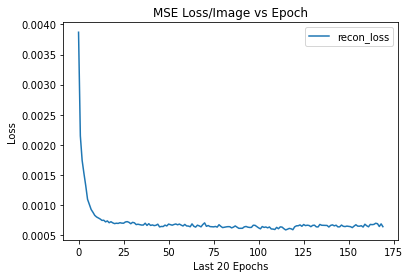

In [274]:
plt.xlabel('Last 20 Epochs')
plt.ylabel('Loss')
plt.title('MSE Loss/Image vs Epoch')

with torch.no_grad():
    # Plotting the last 100 values
    loss_x = []
    loss_y = []
    loss_z = []
    
    for epoch in losses_epoch:
        loss_x.append(sum(epoch)/len(epoch))
    
    for epoch in recon_losses_epoch:
        loss_y.append(sum(epoch)/len(epoch))
    
    for epoch in kl_losses_epoch:
        loss_z.append(sum(epoch)/len(epoch))
        
#     plt.plot(loss_x[:], label='overall loss')
    plt.plot(loss_y[:], label='recon_loss')
#     plt.plot(loss_z[:], label='kl_loss')
    plt.legend()


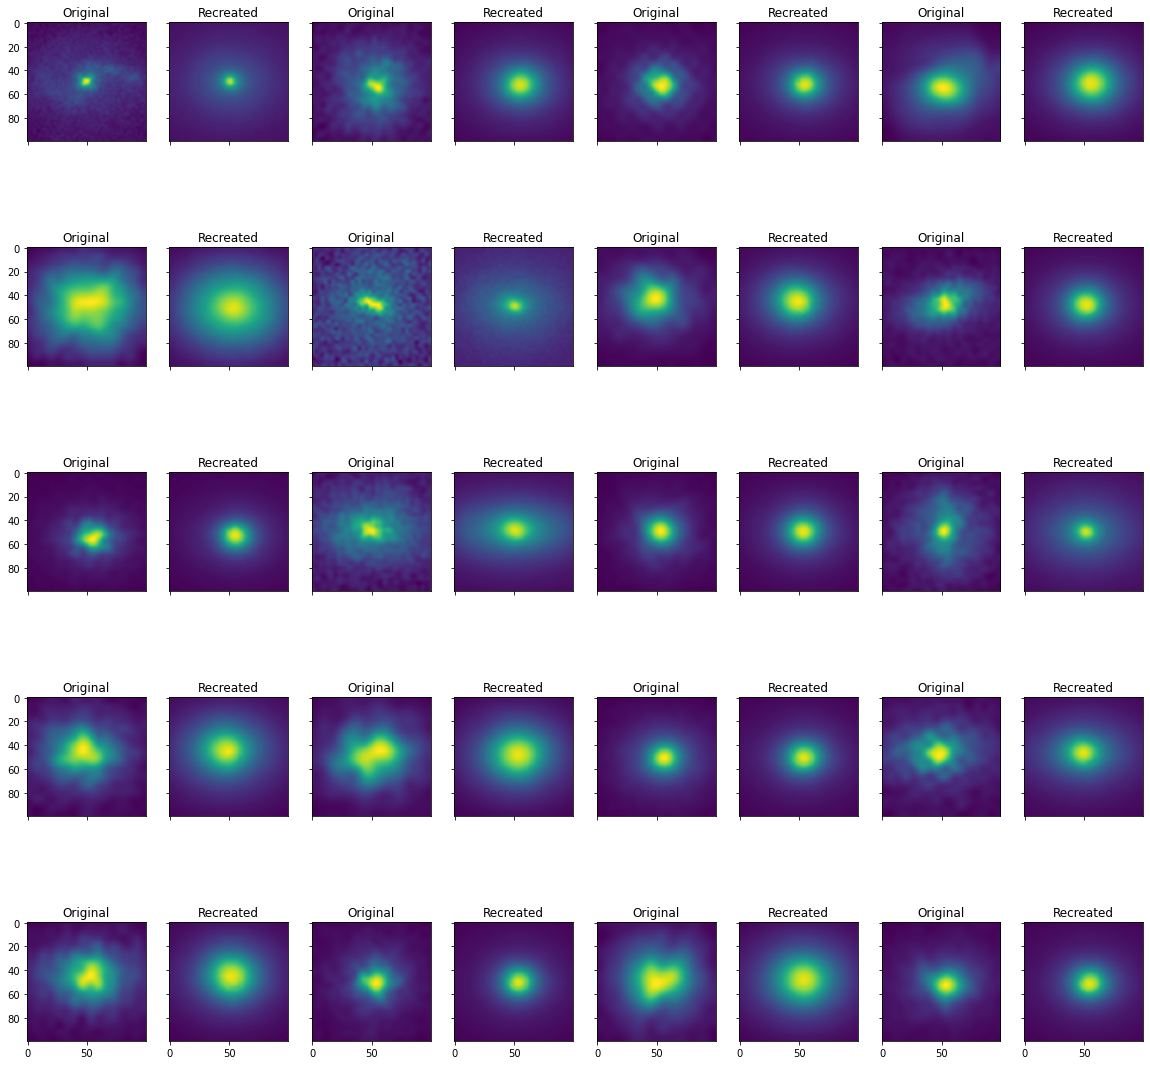

In [275]:
fig, axes = plt.subplots(5, 8, figsize=(20, 20), sharex=True, sharey=True)
ax = axes.ravel()
with torch.no_grad():
    i = 0
    for output in outputs:
        item = output[0]
        rec = output[1]

        # Reshape the array for plotting
        item = item.reshape(-1, 100, 100)
        ax[i].imshow(item[0], vmin=0, vmax=1)
        ax[i].set_title('Original')


        rec = rec.reshape(-1, 100, 100)
        ax[i+1].imshow(rec[0], vmin=0, vmax=1)
        ax[i+1].set_title('Recreated')
        
        i += 2
        
        if i == 100:
            break

In [272]:
torch.save(model.state_dict(), 'vae_model.pt')

with open('vae_loss.pickle', 'wb') as f:
    pickle.dump(losses_epoch, f)
    

# Reinitialise model, input model state_dict.


In [12]:
model = VAE()
model.load_state_dict(torch.load('vae_model.pt'))

<All keys matched successfully>

# Encode the images

In [13]:
temp_ds = GalacticDataset(X=X[:])
temp_loader = torch.utils.data.DataLoader(temp_ds, batch_size=1)

latent_variables = []

i = 1
for image in temp_loader:
    print(i, end='\r')
    with torch.no_grad():
        model.eval()
        mean, log_var = model.encode(image.reshape(-1, 100*100))
        latent_variables.append(mean.numpy()[0])
        model.train()
    i += 1

Text(0.5, 1.0, 'VAE 2D Latent Space')

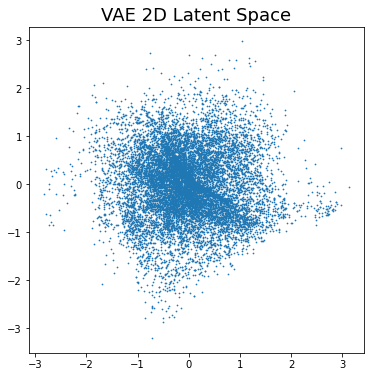

In [14]:
plt.figure(figsize=(6, 6))
plt.scatter(np.array(latent_variables)[:, 0], np.array(latent_variables)[:, 1], s=0.5)
plt.title('VAE 2D Latent Space', fontsize=18)

(array([  33.,  155.,  811., 2465., 4397., 2785., 1411.,  387.,   49.,
          47.]),
 array([-2.8265247 , -2.2313578 , -1.6361908 , -1.0410237 , -0.44585675,
         0.14931023,  0.7444772 ,  1.3396442 ,  1.9348112 ,  2.5299783 ,
         3.1251452 ], dtype=float32),
 <BarContainer object of 10 artists>)

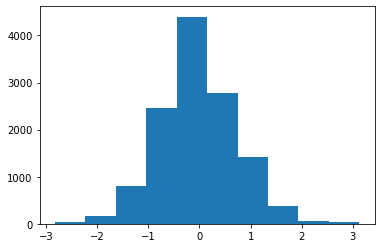

In [308]:
plt.hist(np.array(latent_variables)[:, 0])

(array([  12.,   71.,  339., 1477., 3648., 3966., 2271.,  632.,  106.,
          18.]),
 array([-3.199262  , -2.5815094 , -1.9637568 , -1.3460044 , -0.7282518 ,
        -0.11049926,  0.5072533 ,  1.1250058 ,  1.7427583 ,  2.3605108 ,
         2.9782634 ], dtype=float32),
 <BarContainer object of 10 artists>)

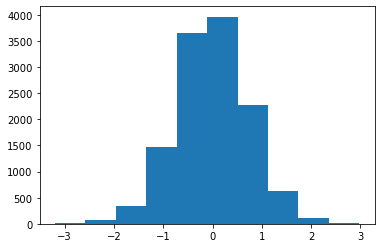

In [309]:
plt.hist(np.array(latent_variables)[:, 1])

In [310]:
rcsed = Table.read('rcsedzoogz2.fits', format='fits')
data = rcsed.to_pandas()
data['radec'] = data['ra_1'].astype(str) + ',' + data['dec_1'].astype(str)
  

In [311]:
with open('cls.pickle', 'rb') as f:
    cls = pickle.load(f)

In [312]:
sns_df = pd.DataFrame(data=latent_variables)
sns_df['type'] = cls[:]


In [313]:
with open('r50.pickle', 'rb') as f:
    r50_list = pickle.load(f)


In [314]:
sns_df['r50'] = r50_list[:]

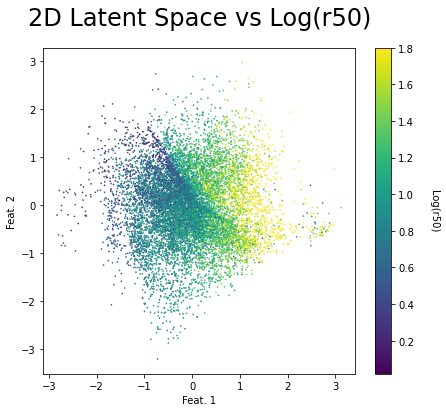

In [315]:
# seaborn pairplot

headers = []

for i, header in enumerate(sns_df.columns[:-2], 1):
    headers.append(f'Feat. {i}')

headers.append('type')
headers.append('r50')
sns_df.columns = headers

plt.figure(figsize=(7, 6))
plt.scatter(x=sns_df['Feat. 1'], y=sns_df['Feat. 2'], c=np.log(sns_df['r50']), s=0.4, vmax=1.8)
plt.title('2D Latent Space vs Log(r50)', fontsize=24, y=1.05)
plt.xlabel('Feat. 1')
plt.ylabel('Feat. 2')

cbar = plt.colorbar()
cbar.set_label('Log(r50)', rotation=270, labelpad=25)


[Text(0.5, 1.0, '2D Latent Space vs Morphological Type')]

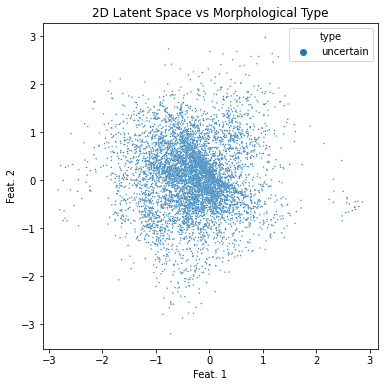

In [317]:
plt.figure(figsize=(6, 6))

sns.scatterplot(x=sns_df[sns_df['type']=='uncertain']['Feat. 1'], 
                y=sns_df[sns_df['type']=='uncertain']['Feat. 2'], 
                hue=sns_df[sns_df['type']=='uncertain']['type'], s=2).set(title='2D Latent Space vs Morphological Type')


[Text(0.5, 1.0, '2D Latent Space vs Morphological Type')]

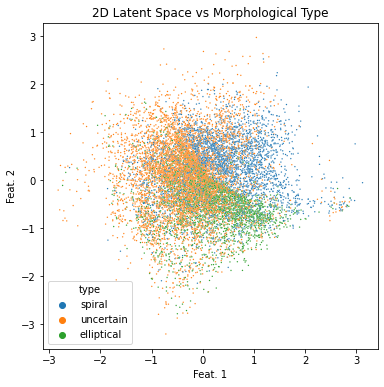

In [318]:
plt.figure(figsize=(6, 6))

sns.scatterplot(x=sns_df['Feat. 1'], 
                y=sns_df['Feat. 2'], 
                hue=sns_df['type'], s=2).set(title='2D Latent Space vs Morphological Type')


# Preparing dataset for pairwise plot with physical/morphological colormapping

In [38]:
# initialise dataframe with galaxy information

rcsed = Table.read('rcsedzoogz2gswlcx.fits', format='fits')
data = rcsed.to_pandas()
data['radec'] = data['ra_1'].astype(str) + ',' + data['dec_1'].astype(str)

i = 0

for j in range(2):
    data[f'Feat. {j+1}'] = None

for n, galaxy in enumerate(full_data.keys(), 0):
    
    try:
        index = data.loc[(data['radec'] == galaxy)].index
        for j in range(len(latent_variables[n])):
            data.at[index[0], f'Feat. {j+1}'] = latent_variables[n][j]

        print(i, end='\r')
        i += 1

    except:
        print(i, end='\r')
        i += 1
        continue
        
final_dataset = data[data['Feat. 1'].isna() == False]
    

/tmp/ipykernel_34163/3873102221.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  cleaned['gz2_class'] = cleaned['gz2_class'].astype(str).str.replace(char, "")


Text(0.5, 1.0, '2D Latent Representation vs Morphology')

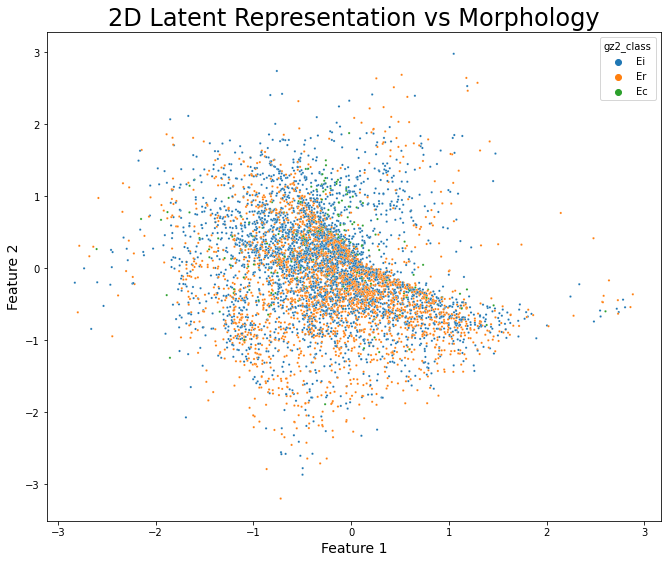

In [73]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot()
   
cleaned = final_dataset.copy()
cleaned['gz2_class'] = cleaned['gz2_class'].astype(str).str.replace("'", "").str.lstrip('b')

for char in ['1', '2', '3', '4', '5', '+', '?', 't', 'm', 'l',]:
    cleaned['gz2_class'] = cleaned['gz2_class'].astype(str).str.replace(char, "")
    
cleaned = cleaned[cleaned['gz2_class'].str[0] == 'E']

sns.scatterplot(data=cleaned, x='Feat. 1', y='Feat. 2', hue='gz2_class',s=5)

ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)

plt.title('2D Latent Representation vs Morphology', fontsize=24, )

In [69]:
c = cleaned['gz2_class'].astype(str).str.replace("'", "")
c.str.lstrip('b').unique()

array(['Sc', 'Sb', 'SBc', 'SBb', 'Sd', 'SBd', 'Sa', 'SBa'], dtype=object)

# 2D Latent Space vs Petrosian R50

Text(0.5, 1.0, '2D Latent Representation vs Log Petrosian R50')

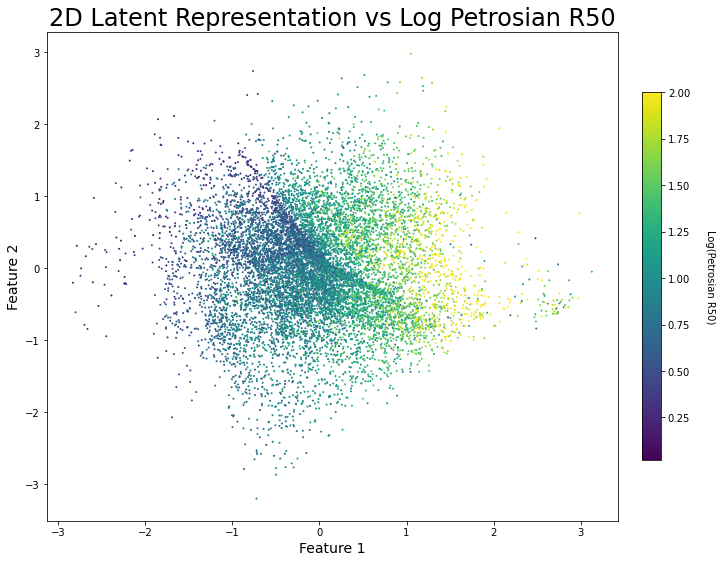

In [321]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot()

x = final_dataset['Feat. 1']
y = final_dataset['Feat. 2']

c = final_dataset['petror50_r']
p = ax.scatter(x, y, s=1, c=np.log(c), vmax=2)
    
ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)

cbar = fig.colorbar(p, fraction=0.03, pad=0.04)
cbar.set_label('Log(Petrosian R50)', rotation=270, labelpad=25)
plt.title('2D Latent Representation vs Log Petrosian R50', fontsize=24, )

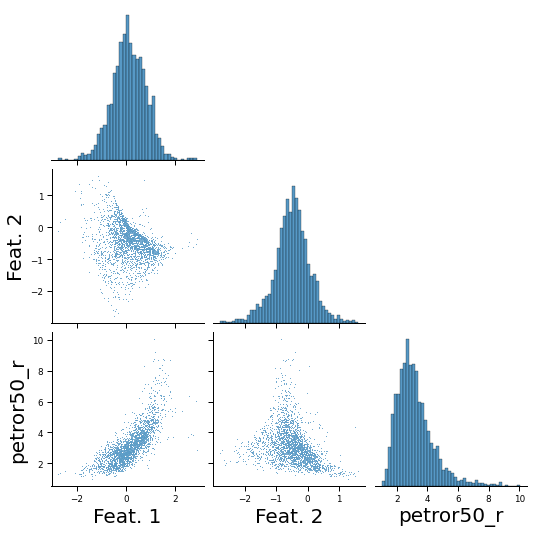

In [322]:
sub = final_dataset[final_dataset['elliptical'] == 1]
sub = sub.loc[:, ['Feat. 1', 'Feat. 2', 'petror50_r',]]

sns.set_context("paper", rc={"axes.labelsize":20})
pp = sns.pairplot(data=sub, palette='hls',corner=True, plot_kws={"s": 1})

# 2D Latent Space vs Metallicity

Text(0.5, 1.0, '2D Latent Representation vs Log Petrosian R50')

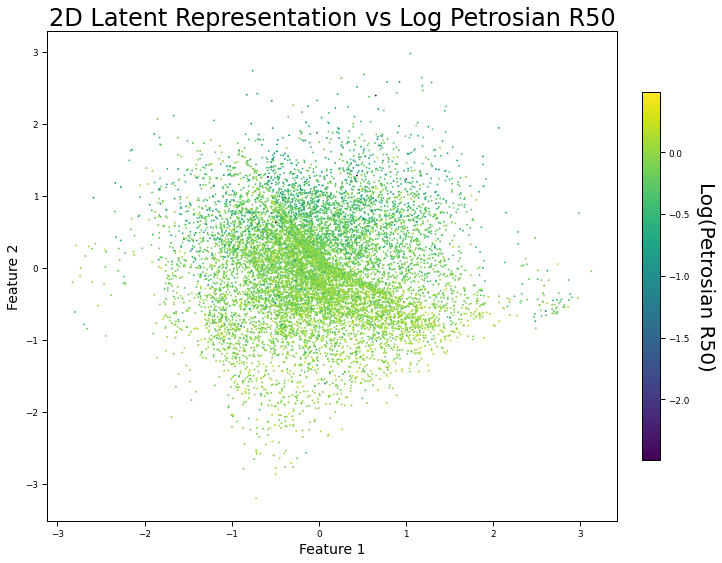

In [323]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot()

x = final_dataset['Feat. 1']
y = final_dataset['Feat. 2']

c = final_dataset['exp_met']
p = ax.scatter(x, y, s=1, c=(c) )
    
ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)

cbar = fig.colorbar(p, fraction=0.03, pad=0.04)
cbar.set_label('Log(Petrosian R50)', rotation=270, labelpad=25)
plt.title('2D Latent Representation vs Log Petrosian R50', fontsize=24, )

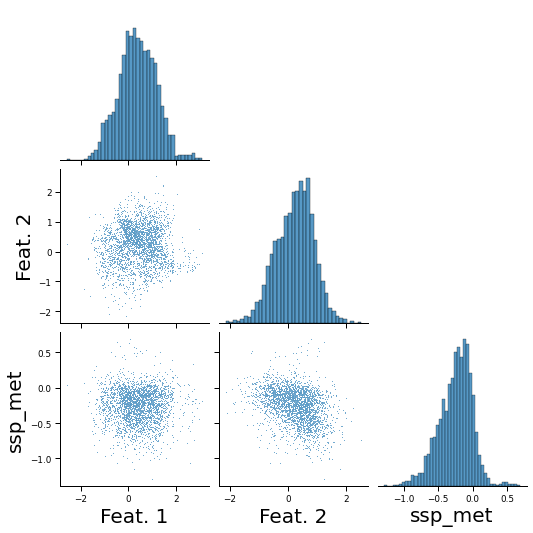

In [324]:
sub = final_dataset[final_dataset['spiral'] == 1]
sub = sub.loc[:, ['Feat. 1', 'Feat. 2', 'ssp_met',]]

sns.set_context("paper", rc={"axes.labelsize":20})
pp = sns.pairplot(data=sub, palette='hls',corner=True, plot_kws={"s": 1})

# 2D Latent Space vs Radial Velocity

Text(0.5, 1.0, '2D Latent Representation vs Log Petrosian R50')

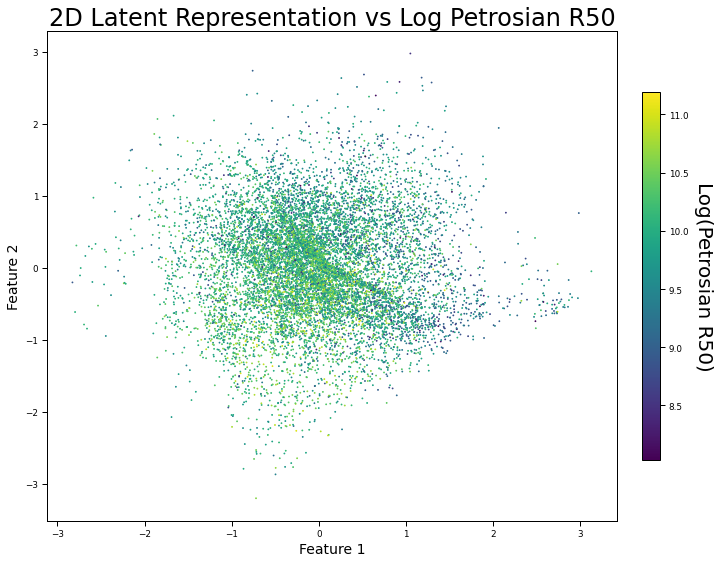

In [325]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot()

x = final_dataset['Feat. 1']
y = final_dataset['Feat. 2']

c = final_dataset['ssp_radvel']
p = ax.scatter(x, y, s=1, c=np.log(c) )
    
ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)

cbar = fig.colorbar(p, fraction=0.03, pad=0.04)
cbar.set_label('Log(Petrosian R50)', rotation=270, labelpad=25)
plt.title('2D Latent Representation vs Log Petrosian R50', fontsize=24, )

/tmp/ipykernel_4138324/4215062154.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['log'] = np.log(sub['ssp_radvel'])


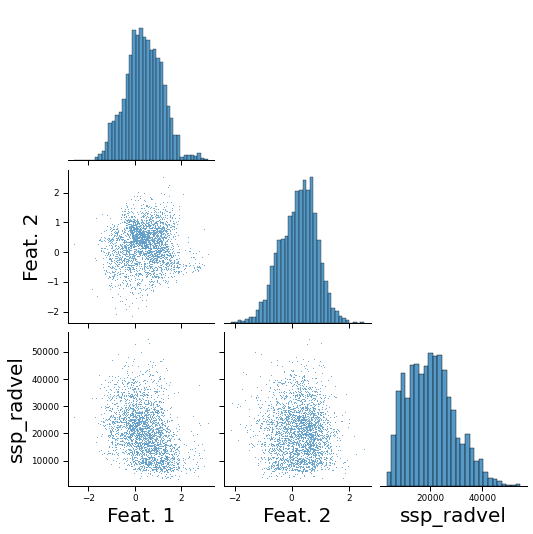

In [326]:
sub = final_dataset[final_dataset['spiral'] == 1]
sub['log'] = np.log(sub['ssp_radvel'])
sub = sub.loc[:, ['Feat. 1', 'Feat. 2', 'ssp_radvel',]]

sns.set_context("paper", rc={"axes.labelsize":20})
pp = sns.pairplot(data=sub, palette='hls',corner=True, plot_kws={"s": 1})

# 2D Latent Space vs Age

Text(0.5, 1.0, '2D Latent Representation vs Age (SSP) Myr')

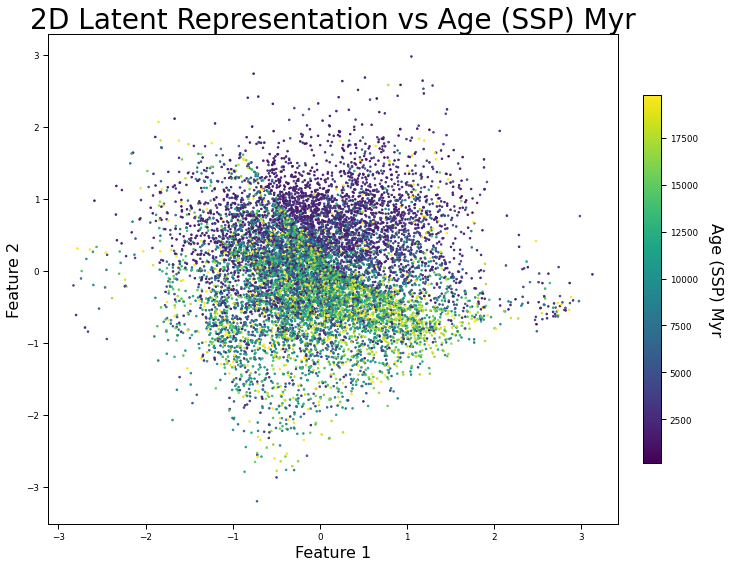

In [363]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot()

x = final_dataset['Feat. 1']
y = final_dataset['Feat. 2']

c = final_dataset['ssp_age']
p = ax.scatter(x, y, s=3, c=(c) )
    
ax.set_xlabel('Feature 1', fontsize=16)
ax.set_ylabel('Feature 2', fontsize=16)

cbar = fig.colorbar(p, fraction=0.03, pad=0.04)
cbar.set_label('Age (SSP) Myr', rotation=270, labelpad=25, fontsize=16)
plt.title('2D Latent Representation vs Age (SSP) Myr', fontsize=28, )

# 2D Latent Space vs LOG SSFR

Text(0.5, 1.0, '2D Latent Representation vs LOGSSFR')

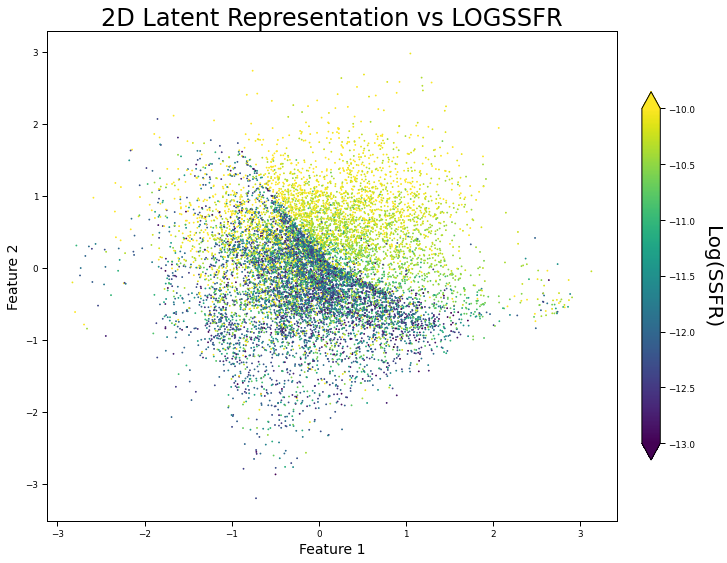

In [364]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot()

sub = final_dataset[final_dataset['LOGMSTAR'] != -99]
x = sub['Feat. 1']
y = sub['Feat. 2']

c = np.exp(sub['LOGSFRSED'])/np.exp(sub['LOGMSTAR'])
p = ax.scatter(x, y, s=1, c=np.log(c), vmin=-13, vmax=-10, )
    
ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)

cbar = fig.colorbar(p, fraction=0.03, pad=0.04, boundaries=None,  extend='both')
cbar.set_label('Log(SSFR)', rotation=270, labelpad=25)
plt.title('2D Latent Representation vs LOGSSFR', fontsize=24,)

/tmp/ipykernel_4138324/3300941760.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub = final_dataset[final_dataset['LOGMSTAR'] != -99][(final_dataset['spiral'] == 1) ]
/tmp/ipykernel_4138324/3300941760.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['LOGSSFR'] = np.log(np.exp(sub['LOGSFRSED'])/np.exp(sub['LOGMSTAR']))


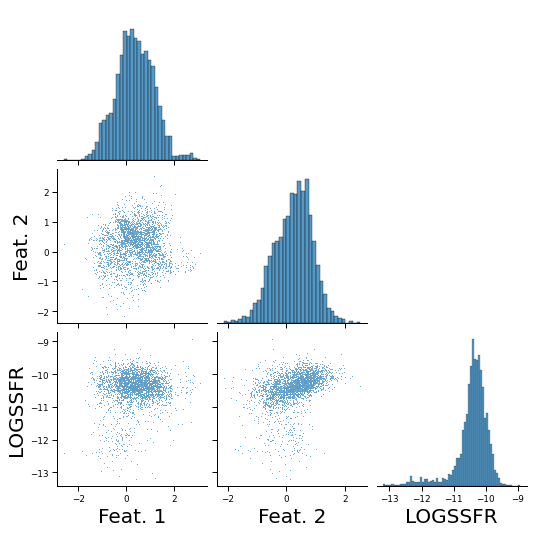

In [365]:
sub = final_dataset[final_dataset['LOGMSTAR'] != -99][(final_dataset['spiral'] == 1) ]
sub['LOGSSFR'] = np.log(np.exp(sub['LOGSFRSED'])/np.exp(sub['LOGMSTAR']))
sub = sub.loc[:, ['Feat. 1', 'Feat. 2', 'LOGSSFR',]]

sns.set_context("paper", rc={"axes.labelsize":20})
pp = sns.pairplot(data=sub, palette='hls',corner=True, plot_kws={"s": 1})

# Image Scatter Plot

Text(0, 0.5, 'Feat. 2')

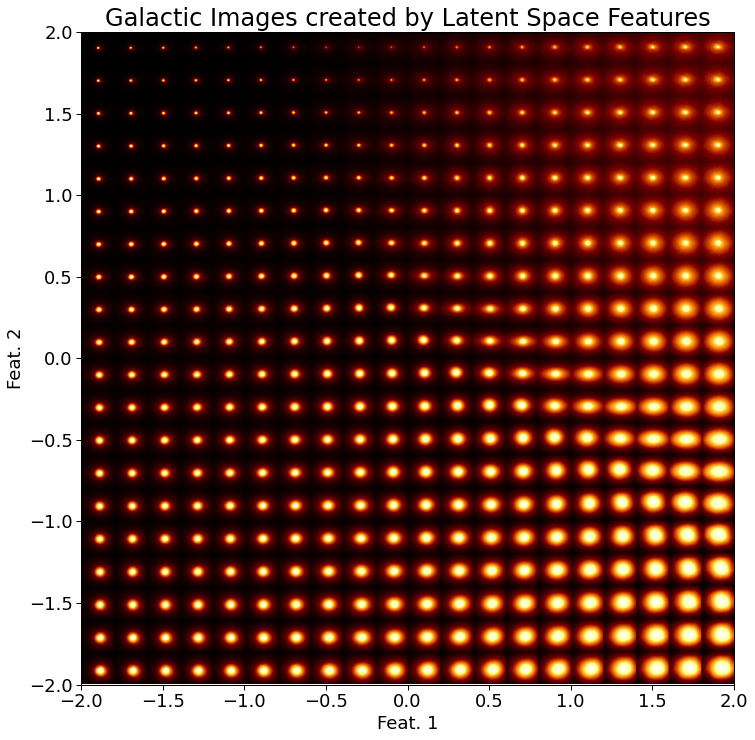

In [437]:
def plot_reconstructed(autoencoder, r0=(-2, 2), r1=(-2, 2), n=20):
    w = 100
    img = np.zeros((n*w, n*w))
    model.eval()
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.from_numpy(np.array([y, x]).astype('float32')).reshape((1, 2))
            x_hat = model.decoder(z)

            x_hat = x_hat.reshape(w, w).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
            
    model.train()
    plt.imshow(img, extent=[*r0, *r1], cmap=plt.cm.afmhot)
    
plt.figure(figsize = (12, 12))
plot_reconstructed(model)
plt.title('Galactic Images created by Latent Space Features', fontsize=24)
plt.tick_params(labelsize=18)
plt.xlabel('Feat. 1', fontsize=18)
plt.ylabel('Feat. 2', fontsize=18)

# Outlier Detection

In [75]:
with open('odd_full_data.pickle', 'rb') as f:
    odd_full_data = pickle.load(f)
    

In [76]:
odd_scaled_data = []

for img in list(odd_full_data.values())[:]:
    scale_factor = 1/(img.max()-img.min())
    img_scaled = (img-img.min())*scale_factor
    odd_scaled_data.append(img_scaled)

odd_scaled_data = np.array(odd_scaled_data)
     

In [77]:
X_odd = odd_scaled_data[:]
dataset_odd = GalacticDataset(X=X_odd[:])
loader_odd = torch.utils.data.DataLoader(dataset_odd, batch_size=1,)

In [78]:
odd_latent_variables = []

i = 1
for image in loader_odd:
    print(i, end='\r')
    with torch.no_grad():
        model.eval()
        mean, log_var = model.encode(image.reshape(-1, 100*100))
        odd_latent_variables.append(mean.numpy()[0])
        model.train()
    i += 1

In [79]:
rcsed = Table.read('rcsedzoogz2.fits', format='fits')
odd_data = rcsed.to_pandas()
odd_data['radec'] = odd_data['ra_1'].astype(str) + ',' + odd_data['dec_1'].astype(str)
  
    
i = 0

for j in range(2):
    odd_data[f'Feat. {j+1}'] = None

for n, galaxy in enumerate(odd_full_data.keys(), 0):
    
    try:
        index = odd_data.loc[(odd_data['radec'] == galaxy)].index
        for j in range(len(odd_latent_variables[n])):
            odd_data.at[index[0], f'Feat. {j+1}'] = odd_latent_variables[n][j]

        print(i, end='\r')
        i += 1

    except:
        print(i, end='\r')
        i += 1
        continue
        
odd_final_dataset = odd_data[odd_data['Feat. 1'].isna() == False]

[Text(0.5, 1.0, '2D Latent Space vs Morphological Type')]

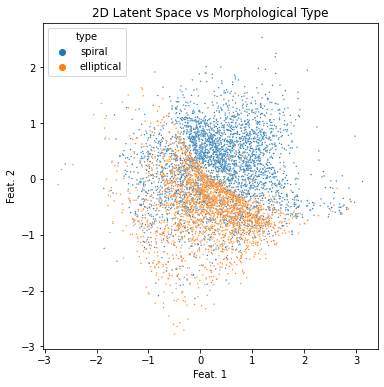

In [316]:
plt.figure(figsize=(6, 6))

sns.scatterplot(x=sns_df[sns_df['type']!='uncertain']['Feat. 1'], 
                y=sns_df[sns_df['type']!='uncertain']['Feat. 2'], 
                hue=sns_df[sns_df['type']!='uncertain']['type'], s=2).set(title='2D Latent Space vs Morphological Type')


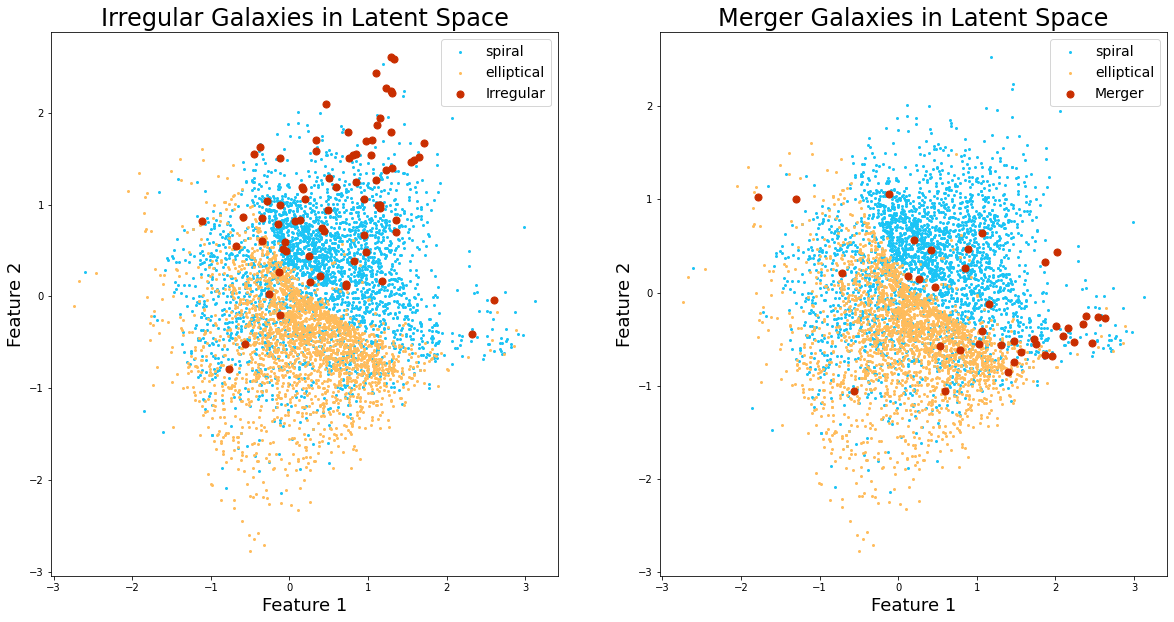

In [116]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
ax = axes.ravel()

oddities = ['t08_odd_feature_a22_irregular_flag', 't08_odd_feature_a24_merger_flag', ]
oddities_rename = ['Irregular', 'Merger', ]


for i in range(len(oddities)):
    
    oddity = oddities[i]
    name = oddities_rename[i]
    
    sub = odd_final_dataset[odd_final_dataset[oddity] == 1]
    x2 = sub['Feat. 1']
    y2 = sub['Feat. 2']

    sub1 = final_dataset[final_dataset['spiral'] == 1]
    sub2 = final_dataset[final_dataset['elliptical'] == 1]
    
    ax[i].scatter(sub1['Feat. 1'], sub1['Feat. 2'], s=4, c='#1bc4f5', label='spiral')
    ax[i].scatter(sub2['Feat. 1'], sub2['Feat. 2'], s=4, c='#ffbc5c', label='elliptical')
    
    ax[i].scatter(x2, y2, c='#c92e00', label=name, s=50)
    ax[i].set_xlabel('Feature 1', fontsize=18)
    ax[i].set_ylabel('Feature 2', fontsize=18)
    ax[i].legend(fontsize=14)
    
    ax[i].set_title(f'{name} Galaxies in Latent Space', fontsize=24)
    

Text(0.5, 0.98, 'Irregular Galaxies in 2D Latent Space')

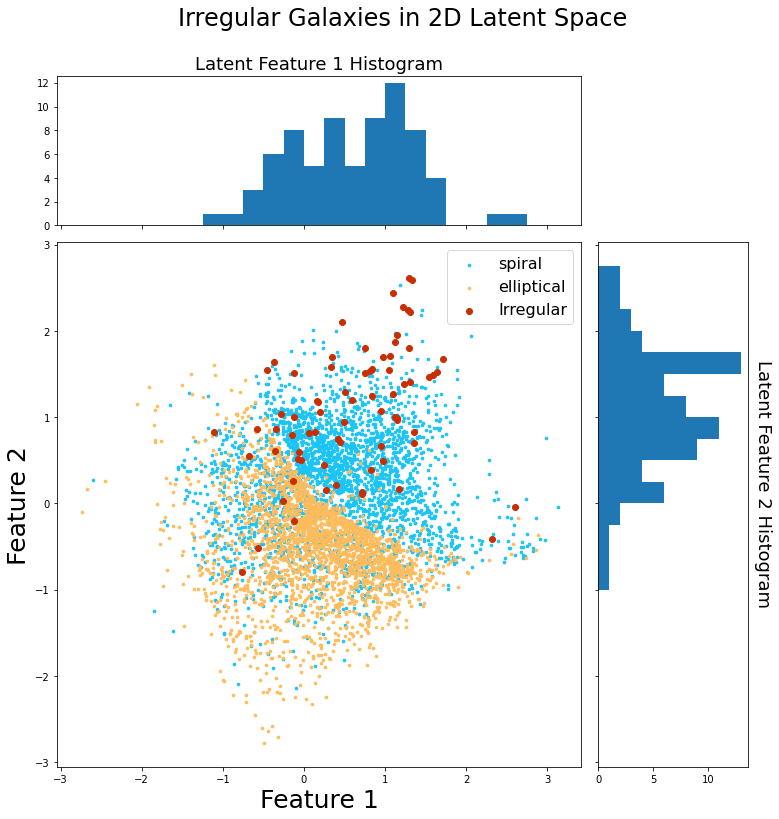

In [191]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, c='#c92e00', label=oddities_rename[0])
    ax.legend(fontsize=16)
    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')
    

fig = plt.figure(figsize=(12, 12))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax.set_xlabel('Feature 1', fontsize=25)
ax.set_ylabel('Feature 2', fontsize=25)

# fig.set_title(f'{oddities_rename[0]} Galaxies in Latent Space', fontsize=24)

sub = odd_final_dataset[odd_final_dataset[oddities[0]] == 1]
x2 = sub['Feat. 1']
y2 = sub['Feat. 2']

sub1 = final_dataset[final_dataset['spiral'] == 1]
sub2 = final_dataset[final_dataset['elliptical'] == 1]

ax.scatter(sub1['Feat. 1'], sub1['Feat. 2'], s=7, c='#1bc4f5', label='spiral')
ax.scatter(sub2['Feat. 1'], sub2['Feat. 2'], s=7, c='#ffbc5c', label='elliptical')
scatter_hist(x2, y2, ax, ax_histx, ax_histy)

ax_histx.set_title('Latent Feature 1 Histogram', fontsize=18)
ax_histy.set_title('Latent Feature 2 Histogram', rotation='270', x=1.1, y=0.3, fontsize=18)
plt.suptitle('Irregular Galaxies in 2D Latent Space', fontsize=24)

Text(0.5, 0.98, 'Merging Galaxies in 2D Latent Space')

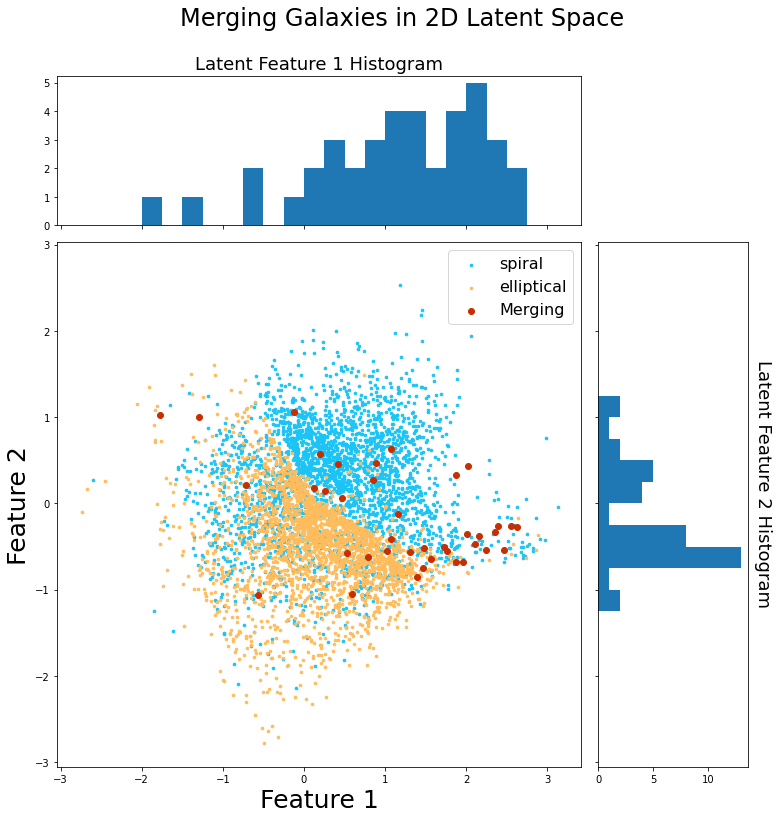

In [ ]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, c='#c92e00', label='Merging')
    ax.legend(fontsize=16)
    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')
    

fig = plt.figure(figsize=(12, 12))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax.set_xlabel('Feature 1', fontsize=25)
ax.set_ylabel('Feature 2', fontsize=25)

# fig.set_title(f'{oddities_rename[0]} Galaxies in Latent Space', fontsize=24)

sub = odd_final_dataset[odd_final_dataset[oddities[1]] == 1]
x2 = sub['Feat. 1']
y2 = sub['Feat. 2']

sub1 = final_dataset[final_dataset['spiral'] == 1]
sub2 = final_dataset[final_dataset['elliptical'] == 1]

ax.scatter(sub1['Feat. 1'], sub1['Feat. 2'], s=7, c='#1bc4f5', label='spiral')
ax.scatter(sub2['Feat. 1'], sub2['Feat. 2'], s=7, c='#ffbc5c', label='elliptical')
scatter_hist(x2, y2, ax, ax_histx, ax_histy)

ax_histx.set_title('Latent Feature 1 Histogram', fontsize=18)
ax_histy.set_title('Latent Feature 2 Histogram', rotation='270', x=1.1, y=0.3, fontsize=18)
plt.suptitle('Merging Galaxies in 2D Latent Space', fontsize=24)

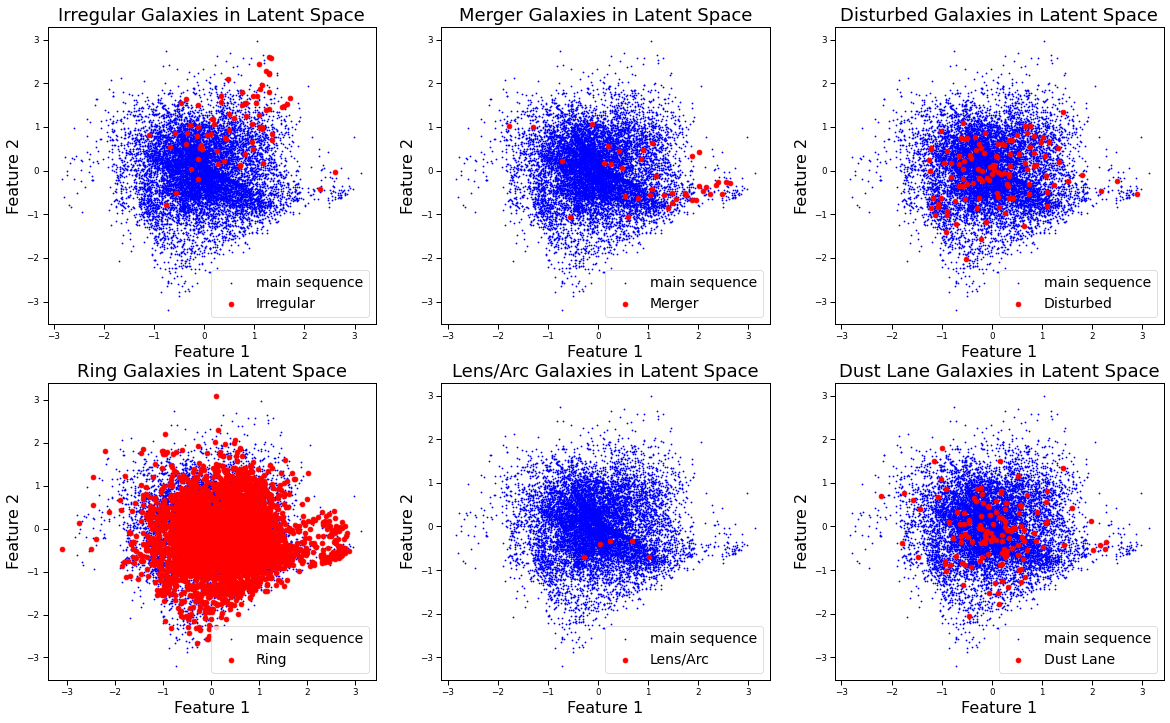

In [440]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
ax = axes.ravel()

x = final_dataset['Feat. 1']
y = final_dataset['Feat. 2']
    

oddities = ['t08_odd_feature_a22_irregular_flag', 't08_odd_feature_a24_merger_flag', 't08_odd_feature_a21_disturbed_flag',
           't08_odd_feature_a19_ring_flag', 't08_odd_feature_a20_lens_or_arc_flag', 't08_odd_feature_a38_dust_lane_flag']

oddities_rename = ['Irregular', 'Merger', 'Disturbed', 'Ring', 'Lens/Arc', 'Dust Lane']


for i in range(len(oddities)):
    
    oddity = oddities[i]
    name = oddities_rename[i]
    
    sub = odd_final_dataset[odd_final_dataset[oddity] == 1 ]
    x2 = sub['Feat. 1']
    y2 = sub['Feat. 2']

    ax[i].scatter(x, y, s=1, c='blue', label='main sequence')

    ax[i].scatter(x2, y2, c='red', label=name)
    ax[i].set_xlabel('Feature 1', fontsize=16)
    ax[i].set_ylabel('Feature 2', fontsize=16)
    ax[i].legend(fontsize=14)
    ax[i].set_title(f'{name} Galaxies in Latent Space', fontsize=18)

Text(0.5, 1.0, 'Merging Galaxies in Latent Space')

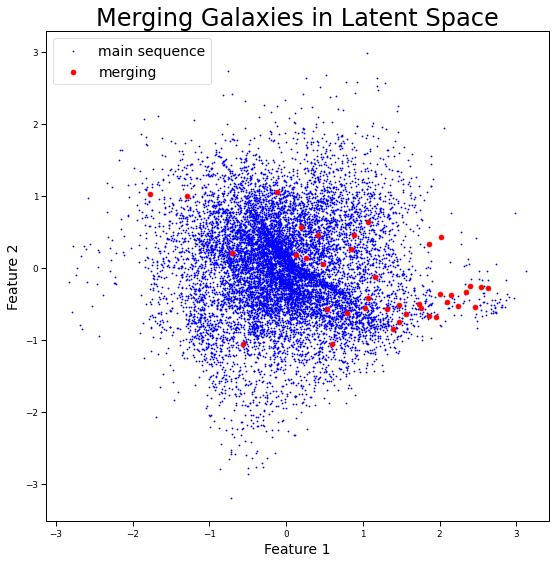

In [413]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot()

x = final_dataset['Feat. 1']
y = final_dataset['Feat. 2']


    
sub = odd_final_dataset[odd_final_dataset['t08_odd_feature_a24_merger_flag'] == 1 ]
x2 = sub['Feat. 1']
y2 = sub['Feat. 2']

p = ax.scatter(x, y, s=1, c='blue', label='main sequence')
p2 = ax.scatter(x2, y2, c='red', label='merging')

ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)

ax.legend(fontsize=14)
plt.title('Merging Galaxies in Latent Space', fontsize=24,)

Text(0.5, 1.0, 'Irregular Galaxies in Latent Space')

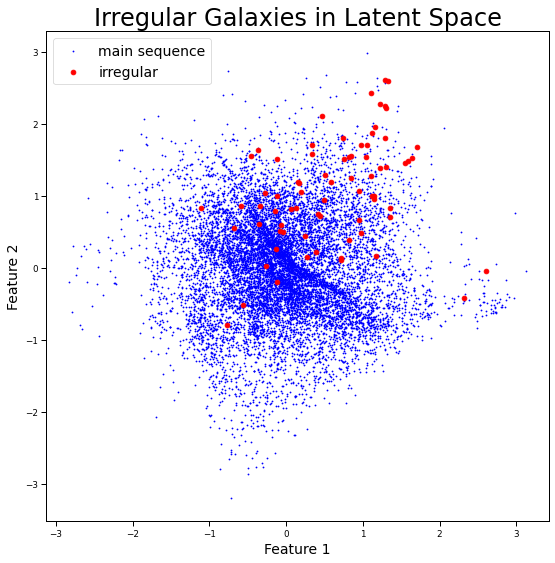

In [412]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot()

x = final_dataset['Feat. 1']
y = final_dataset['Feat. 2']

sub = odd_final_dataset[odd_final_dataset['t08_odd_feature_a22_irregular_flag'] == 1 ]
x2 = sub['Feat. 1']
y2 = sub['Feat. 2']

p = ax.scatter(x, y, s=1, c='blue', label='main sequence')
p2 = ax.scatter(x2, y2, c='red', label='irregular')

ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)

ax.legend(fontsize=14)
plt.title('Irregular Galaxies in Latent Space', fontsize=24,)

# Run first 9 images through Beta-VAE.

AttributeError: 'tuple' object has no attribute 'reshape'

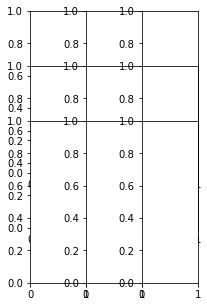

In [141]:
temp_ds = GalacticDataset(X=X[:9])
temp_loader = torch.utils.data.DataLoader(temp_ds, batch_size=1)

temp_outputs = []

for image in temp_loader:
    temp_outputs.append(model(image.reshape(-1, 100*100)))

with torch.no_grad():
    # original 9 galaxies

    fig = plt.figure(figsize=(3, 5), constrained_layout=False)
    outer_grid = fig.add_gridspec(1, 1, wspace=0, hspace=0)

    j = 0

    # gridspec inside gridspec
    inner_grid = outer_grid[0, 0].subgridspec(3, 3, wspace=0, hspace=-0.66)
    axs = inner_grid.subplots()  # Create all subplots for the inner grid.
    for (c, d), ax in np.ndenumerate(axs):
        ax.imshow(temp_outputs[j].reshape((100, 100)))
        ax.set(xticks=[], yticks=[])
        j += 1


    # show only the outside spines

    for i, ax in enumerate(fig.get_axes(), 1):
        ss = ax.get_subplotspec()
        if i == 2:
            ax.set_title('CNN Autoencoder with 8 Dimensional Bottleneck', fontsize=20)
        ax.spines.top.set_visible(ss.is_first_row())
        ax.spines.bottom.set_visible(ss.is_last_row())
        ax.spines.left.set_visible(ss.is_first_col())
        ax.spines.right.set_visible(ss.is_last_col())

    plt.show()
